In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 5s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'imdb.vocab', 'test', 'README']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['labeledBow.feat',
 'pos',
 'urls_unsup.txt',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_neg.txt',
 'unsup']

In [5]:
sample_file=os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [7]:
os.listdir(train_dir)

['labeledBow.feat',
 'pos',
 'urls_unsup.txt',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_neg.txt']

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split = 0.2,
    subset = "training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f'recenzja: {text_batch.numpy()[i]}')
    print(f'etykieta: {label_batch.numpy()[i]}')

recenzja: b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
etykieta: 1
recenzja: b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of mad

In [13]:
print(f"Etykieta 0 -> {raw_train_ds.class_names[0]}")
print(f"Etykieta 1 -> {raw_train_ds.class_names[1]}")

Etykieta 0 -> neg
Etykieta 1 -> pos


In [19]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split = 0.2,
    subset = "validation",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [20]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [24]:
#standardyzacja tekstu
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' %re.escape(string.punctuation),'')


In [25]:
#wektoryzacja tekstu
max_features = 10_000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [26]:
train_text = raw_test_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [28]:
def vectorized_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [29]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review,first_label = text_batch[0],label_batch[0]
print(f'Etykieta: {first_label}')
print(f'Recenzja: {first_review}')
print(f'widok zwektoryzowany: {vectorized_text(first_review,first_label)}')

Etykieta: 0
Recenzja: b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><b

In [32]:
print(f'740 --> {vectorize_layer.get_vocabulary()[716]}')
print(f'1287 --> {vectorize_layer.get_vocabulary()[1287]}')
print(f'313 --> {vectorize_layer.get_vocabulary()[313]}')
print(f'2 --> {vectorize_layer.get_vocabulary()[2]}')
print(f'5858 --> {vectorize_layer.get_vocabulary()[5858]}')

740 --> havent
1287 --> boyfriend
313 --> shot
2 --> the
5858 --> toys


In [33]:
print(f'rozmiar słownika: {len(vectorize_layer.get_vocabulary())}')

rozmiar słownika: 10000


In [37]:
train_ds = raw_train_ds.map(vectorized_text)
val_ds = raw_val_ds.map(vectorized_text)
test_ds = raw_test_ds.map(vectorized_text)

In [36]:
#tuning wydajnościowy
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
#tworzenie modelu sieci neuronowej
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [40]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [41]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6651 - binary_accuracy: 0.6764 - val_loss: 0.6172 - val_binary_accuracy: 0.7602
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 0.5534 - binary_accuracy: 0.7904 - val_loss: 0.5047 - val_binary_accuracy: 0.8148
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4504 - binary_accuracy: 0.8392 - val_loss: 0.4263 - val_binary_accuracy: 0.8430
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 0.3831 - binary_accuracy: 0.8645 - val_loss: 0.3793 - val_binary_accuracy: 0.8570
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3410 - binary_accuracy: 0.8762 - val_loss: 0.3503 - val_binary_accuracy: 0.8658
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3109 - binary_accuracy: 0.8852 - val_loss: 0.3312 - val_binary_accuracy: 0.8702
Epoch 7/10
625/625 [==============================] - 7s 

In [42]:
loss,accuracy = model.evaluate(test_ds)

782/782 [==============================] - 4s 5ms/step - loss: 0.3094 - binary_accuracy: 0.8742


In [43]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

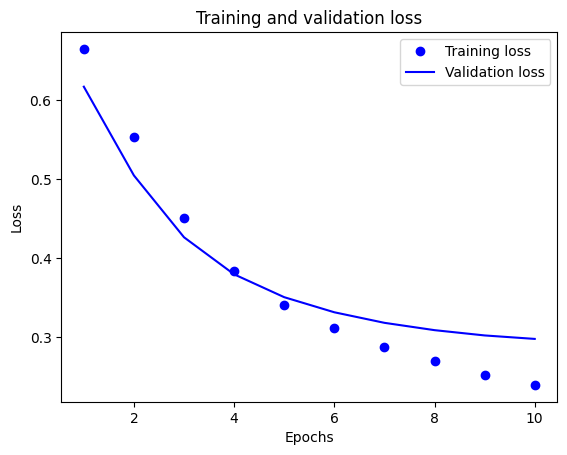

In [44]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()
